# Colour Sementation project

## Learning Objectives
  1. Learn how to read in images 
  2. Intro to numpy for multidimensional data
  3. Learn about RGB
  4. Use KMeans clustering to do colour reduction
  5. Define error function for KMeans

## Import libraries

In [9]:
%matplotlib inline

from google.colab import files    # upload
import numpy as np                # mathematical calculations
from io import BytesIO            # reading files
from PIL import Image             # image processing library
import matplotlib.pyplot as plt   # plotting library
from mpl_toolkits import mplot3d  # 3D plots
import cv2 as cv2

import time
from IPython import display
import random

## Upload image and take a peek

In [10]:
from google.colab import drive
drive.mount('drive')
img = Image.open("/content/drive/MyDrive/Colab Notebooks/Colour Segmentation/cup.jpg")
im = np.array(img)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


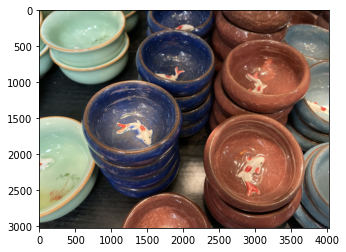

In [11]:
# Show image
plt.imshow(im)

In [12]:
# Convert to numpy array so that we can do stuff
rgb_im = np.array(im)

(125, 200, 3)


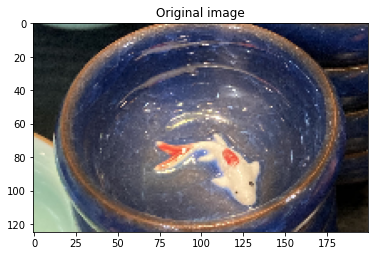

In [13]:
crop = rgb_im[1000:2000:8, 500:2100:8, :] # 400x500 = 200000
print(crop.shape)
plt.title("Original image")
plt.imshow(crop)

# Apply KMeans clustering to find the n most dominant average colours for representing your image. 


1. Randomly pick k initial center 

  colour 1, colour 2, ... colour k
  colour = (r, g, b)

2. Assign each pixel to an average colour. Distance = Euclidean

  sqrt(r^2 + g^2 + b^2)

3. Find average of each group/cluster and make the average the new epicentre.   

4. Rpeat 2, 3 for max_itr number of times. 




In [14]:
def distance(c1, c2):
  return np.sqrt(
      np.square(c1[0]-c2[0]) + np.square(c1[1]-c2[1]) + np.square(c1[2]-c2[2]))

def assign(centres, image):
  """
  imput:
    centres: dict of rbg arrays
    image: 3D coloured image
  
  output:
    dict - cluster number mapping to list of pixels 
  """
  # Initialize our output dict
  output = {}
  for key, value in centres.items():
    output[key] = []

  nrows, ncols, d = image.shape
  for i in range(nrows):
    for j in range(ncols):

      # loop over each centre
      min_dist = np.inf
      min_centre = None

      # call the distance function and find the centre where the pixel has the min distance
      for centre_num, centre in centres.items():
        d = distance(centre, image[i,j,:])
        if d < min_dist:
          min_dist = d
          min_centre = centre_num

      # assign to closest centre
      output[min_centre].append((i, j))

  return output

def find_centroid(list_of_pixels, image):
  """
  Input:
    list_of_pixels - list of pixel location [row, col]
    image: 3D coloured image

  Output:
    new_centre: new rbg array
  """
  num_pixels = len(list_of_pixels)

  # If the number of pixels is zero, make a new random centroid
  if num_pixels == 0:
    return list([random.randint(0,255), random.randint(0,255), random.randint(0,255)])

  mean_r = 0
  mean_g = 0
  mean_b = 0

  # Loop over each pixel
  for pixel in list_of_pixels:
    row = pixel[0]
    col = pixel[1]

    # Add rgb values
    mean_r += image[row, col, 0]
    mean_g += image[row, col, 1]
    mean_b += image[row, col, 2]

  # Find average -- convert to int
  new_centre = list([int(mean_r/num_pixels), int(mean_g/num_pixels), int(mean_b/num_pixels)])
  return new_centre


def im2plot(image, centroids, clusters):
  """
  Plotting function to plot each pixel in the same cluster with the 
  colour of the cluster.

  Input:
    image - original 3D image
    centroids - dict mapping centroid number to rbg colour as a list
    clusters - dict mapping centroid number to list of pixels in that centroid

  Output: 
    cluster_im - a new image where each pixel shows the colour of the 
                 cluster it belongs to
  """
  # Steps:
  # 1. We need to make a new image that has the same dimensions as the old one
  # new_im = old_im.copy()
  # 2. Go through each cluster i
  #    For each cluster, assign all pixels in the cluster to the colour of the centroid
  #    new_colour = centroids[i]
  #    new_red = new_colour[0], new_green = new_colour[1], ...
  # 3. Assign
  #    new_im[row, col, 0] = new_red ...
  # 4. return new_img

  # Copy the original image for the same dimensions
  cluster_im = image.copy()

  # Loop through each cluster
  for cluster_num, colour in centroids.items():
    list_of_pixels = clusters[cluster_num]
    r = colour[0]
    g = colour[1]
    b = colour[2]

    # Go through each pixel
    for pixel in list_of_pixels:
      row = pixel[0]
      col = pixel[1]

      # Assign new colour to the pixel
      cluster_im[row, col, 0] = r
      cluster_im[row, col, 1] = g
      cluster_im[row, col, 2] = b

  return cluster_im

def error(im1, im2):
  """
  Takes in two images, and returns the sum of the colour distances between them

  Inputs:
    im1 - 3d numpy array, first 2 dims are pixel location, 3rd is the rgb
    im2 - 3d numpy array

  Output:
    error - float of the sum of all of the colour distances for each pixel
  """
  red_diff = im1[:,:,0] - im2[:,:,0] # the difference of all red pixels across 2 images
  green_diff = im1[:,:,1] - im2[:,:,1] # the difference of all greens
  blue_diff = im1[:,:,2] - im2[:,:,2] # the difference of all blues

  err = np.sqrt(np.square(red_diff) + np.square(green_diff) + np.square(blue_diff)).astype(np.float32)

  # Normalize to max of black to white
  err = err/np.sqrt(np.square(255) + np.square(255) + np.square(255))

  # Use np.sum()
  total_err = np.sum(err)

  # Noramlize with repsect to num pixels in image
  w = err.shape[0]
  h = err.shape[1]

  return 100*total_err/(w*h)

"""
  red_diff = im1[:,:,0] - im2[:,:,0] # the difference of all red pixels across 2 images
  green_diff = im1[:,:,1] - im2[:,:,1] # the difference of all greens
  blue_diff = im1[:,:,2] - im2[:,:,2] # the difference of all blues

  err = np.sqrt(
      np.square(red_diff) + np.square(green_diff) + np.square(blue_diff)
      )
  
  # Nomalize
  err = err.astype(np.float32)
  err = err/err.max()

  # Divide by total number of pixels in your image
  w = err.shape[0]
  h = err.shape[1]

  return np.sum(err)/(w*h)
"""

'\n  red_diff = im1[:,:,0] - im2[:,:,0] # the difference of all red pixels across 2 images\n  green_diff = im1[:,:,1] - im2[:,:,1] # the difference of all greens\n  blue_diff = im1[:,:,2] - im2[:,:,2] # the difference of all blues\n\n  err = np.sqrt(\n      np.square(red_diff) + np.square(green_diff) + np.square(blue_diff)\n      )\n  \n  # Nomalize\n  err = err.astype(np.float32)\n  err = err/err.max()\n\n  # Divide by total number of pixels in your image\n  w = err.shape[0]\n  h = err.shape[1]\n\n  return np.sum(err)/(w*h)\n'

In [15]:
k = 12
max_itr = 80

In [16]:
# Initialize random centroids to start
randR = np.random.uniform(low=0, high=1, size=k)*255
randG = np.random.uniform(low=0, high=1, size=k)*255
randB = np.random.uniform(low=0, high=1, size=k)*255

# Make an initial dict of centres
centres = {i:[int(randR[i]), int(randG[i]), int(randB[i])] for i in range(k)}

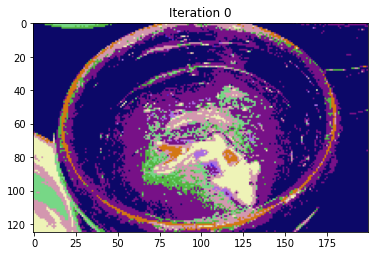

In [17]:
# Plot graph with your random colours
clusters = assign(centres, crop) # dict mapping cluster number to list of pixels
im = im2plot(crop, centres, clusters)
plt.title("Iteration 0")
plt.imshow(im)

In [18]:
# Call my error function with the original and clustered images
err = error(im, crop)
print(err)

2.402321044921875


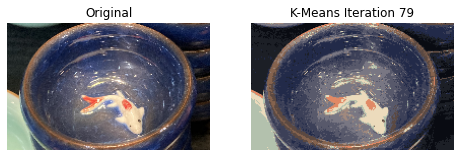

In [19]:
error_log = {}
itr = 0

while itr < max_itr:
  # Get clustering
  clusters = assign(centres, crop)
  
  # Try plotting the new image
  try:
    # Get colour clustered image
    im = im2plot(crop, centres, clusters)

    # Calculate error and store
    error_log[itr] = error(im, crop)

    # Plotting code
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 3])
    ax1.set_title('Original')
    ax2.set_title("K-Means Iteration %d" % itr)
    im1 = ax1.imshow(crop, cmap="gray")
    im2 = ax2.imshow(im, cmap="gray")
    ax1.axis('off')
    ax2.axis('off')

    # Save image for each iteration
    fig.savefig("/content/drive/MyDrive/Colab Notebooks/Colour Segmentation/" + "{}-itr.png".format(itr))
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1) # This keeps the plot on until the next plot is ready
    plt.close()
  except KeyboardInterrupt:
      break

  # Get new centres:
  centres = {}
  for i in range(k):
    centres[i] = find_centroid(clusters[i], crop)

  itr += 1 

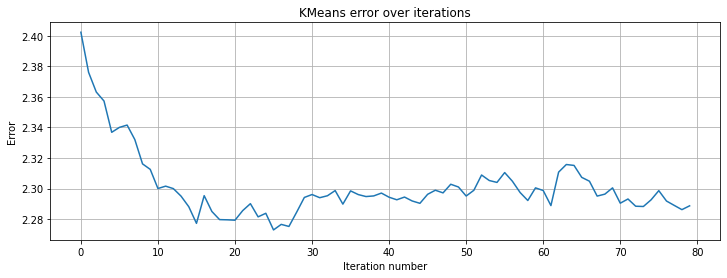

In [20]:
fig = plt.figure(figsize=(12, 4))
plt.plot(list(error_log.keys()), list(error_log.values()))
plt.title("KMeans error over iterations")
plt.xlabel("Iteration number")
plt.ylabel("Error")
plt.grid('on')
plt.show()

## Defining Error: How different is our reduced image from the original?

Answering this question is important because allows us to:
- evaluate how many iterations we need to run the KMeans clustering
- pick a proper number of clusters to use  
- determine how the inital random choices influence our clustering results

What is a good error metric? How would you go about measuring the error?
 Error: difference between the original and the result



 1. How many pixels are different from the original
 2. Error = for each pixel, the distance between the original colour of the pixel and the clustered colour of the pixel

$$Error =  \sqrt{(r_{original} - r_{clustered})^2 + (g_{original} - g_{clustered})^2 + (b_{original} - b_{clustered})^2}$$

Helpful functions:
- np.square() : element wise squaring
- np.sqrt(): element wise sqrt
- np.sum() : sums values of each entry in numpy array into float


## KMeans is an Unsupervised Machine Learning algorithm

1. How do we determine the best number of iterations?
2. How do we determine the best number of clusters?


## Colour Segmentation
- Altering images
- Edge detection






In [21]:
centres

{0: [120, 117, 130],
 1: [60, 64, 87],
 2: [91, 73, 66],
 3: [134, 100, 79],
 4: [236, 219, 188],
 5: [223, 136, 100],
 6: [34, 41, 73],
 7: [28, 31, 38],
 8: [157, 138, 131],
 9: [9, 11, 18],
 10: [179, 194, 174],
 11: [88, 88, 106]}

In [22]:
def alter_single_centroid(image, centroid_number, clusters, new_colour):
  """
  Take in an already image segmented image. Given a new colour and the old
  colour it should replace, output a new image with the new colour. 
  
  Input:
    image - the already clustered image
    centroid_number - integer key in our dicts mapping cluster number to each centroid colour
    clusters - dict mapping cluster number to list of pixels belonging in that cluster
    new_colour - a list of rgb [r, g, b]
  
  Output:
    new_im - the new image with altered colour
  """
  # start by making a copy of our colour segmented result
  new_im = image.copy()

  # change the colour for all pixels that correspond to the specific cluster number
  for px in clusters[centroid_number]:
    new_im[px[0], px[1], 0] = new_colour[0] # set new r
    new_im[px[0], px[1], 1] = new_colour[1] # set new g
    new_im[px[0], px[1], 2] = new_colour[2] # set new b

  return new_im

In [23]:
new_colour = [192, 174, 194]
altered = alter_single_centroid(im, 7, clusters, new_colour)

(-0.5, 199.5, 124.5, -0.5)

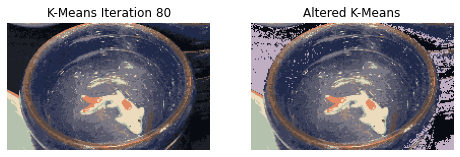

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8, 3])
ax1.set_title("K-Means Iteration %d" % itr)
ax2.set_title("Altered K-Means")
im1 = ax1.imshow(im, cmap="gray")
im2 = ax2.imshow(altered, cmap="gray")
ax1.axis('off')
ax2.axis('off')